## Chatbot

### Input library

In [1]:
from nltk.stem import PorterStemmer 
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential



### load dataset dan preparation

In [3]:
import re
import json
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd

with open('dataset3.json') as f:
    data = json.load(f)

# Load the additional corpus from corpus.json
with open('dataset/corpus/id/agent.json') as f:
    agent = json.load(f)

with open('dataset/corpus/id/dialog.json') as f:
    dialog = json.load(f)

with open('dataset/corpus/id/motivasi.json') as f:
    motivation = json.load(f)

with open('dataset/corpus/id/None.json') as f:
    none = json.load(f)

with open('dataset/corpus/id/user.json') as f:
    user = json.load(f)



# Append the corpus data to the existing data
data['intents'].extend(agent)
data['intents'].extend(dialog)
data['intents'].extend(motivation)
data['intents'].extend(none)
data['intents'].extend(user)


stop_words = set()

with open('stopword_id.txt', 'r', encoding='utf-8') as file:
    for line in file:
        stop_words.add(line.strip())

tags = []
inputs = []
responses = {}
lemmatizer = WordNetLemmatizer()

for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for line in intent['patterns']:
        # Prapemrosesan teks
        line = re.sub('[^a-zA-Z0-9\s]', '', line)
        line = re.sub(r'[.,’"\'-?:!;]', '', line)
        line = re.sub(r'^Apa|^Saya|^Aku|^maukah|^Siapa|^Bagaimana|^Dimana|^Kapan|^Kenapa|^Bisakah', '', line)
        
        # Tokenize each word in the pattern
        w = nltk.word_tokenize(line)
        w = [lemmatizer.lemmatize(word.lower()) for word in w if word not in stop_words]
        inputs.append(' '.join(w))
        tags.append(intent['tag'])

# Create a DataFrame
data_df = pd.DataFrame({"inputs": inputs, "tags": tags})


### print dataset setelah preparation

In [4]:
print(data_df)

                     inputs                    tags
0                feminicare      tentang_feminicare
1                feminicare      tentang_feminicare
2    definisikan feminicare      tentang_feminicare
3                feminicare      tentang_feminicare
4                feminicare      tentang_feminicare
..                      ...                     ...
910                 lakukan        user.needsadvice
911                          user.permission_to_ask
912                          user.permission_to_ask
913                          user.permission_to_ask
914                   nanya  user.permission_to_ask

[915 rows x 2 columns]


### preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Tokenizer
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(data_df['inputs'])

# Encode the outputs
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(data_df['tags'])

# Define input shape
input_shape = 100  # Misalkan panjang maksimum input adalah 100 kata

# Padding sequences
sequences = tokenizer.texts_to_sequences(data_df['inputs'])
x_train = pad_sequences(sequences, maxlen=input_shape, truncating='post')

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


### inisialisasi layer

In [6]:
model = Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 64, input_length=100),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax'),
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



### training model

In [7]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
23/23 [==============================] - 3s 77ms/step - loss: 5.4694 - accuracy: 0.0041 - val_loss: 5.4762 - val_accuracy: 0.0000e+00
Epoch 2/100
23/23 [==============================] - 1s 57ms/step - loss: 5.4165 - accuracy: 0.0096 - val_loss: 5.6826 - val_accuracy: 0.0055
Epoch 3/100
23/23 [==============================] - 1s 55ms/step - loss: 5.3923 - accuracy: 0.0164 - val_loss: 5.5829 - val_accuracy: 0.0055
Epoch 4/100
23/23 [==============================] - 1s 57ms/step - loss: 5.3595 - accuracy: 0.0109 - val_loss: 5.5803 - val_accuracy: 0.0055
Epoch 5/100
23/23 [==============================] - 1s 61ms/step - loss: 5.3273 - accuracy: 0.0164 - val_loss: 5.5385 - val_accuracy: 0.0055
Epoch 6/100
23/23 [==============================] - 1s 55ms/step - loss: 5.2259 - accuracy: 0.0246 - val_loss: 5.5230 - val_accuracy: 0.0164
Epoch 7/100
23/23 [==============================] - 1s 56ms/step - loss: 4.9891 - accuracy: 0.0437 - val_loss: 5.2205 - val_accuracy: 0.0383
Ep

### plot akurasi

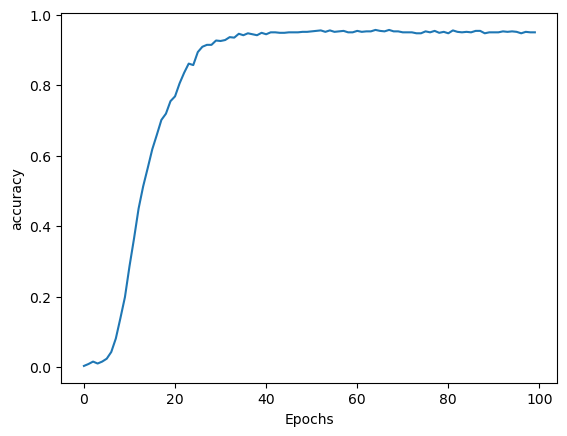

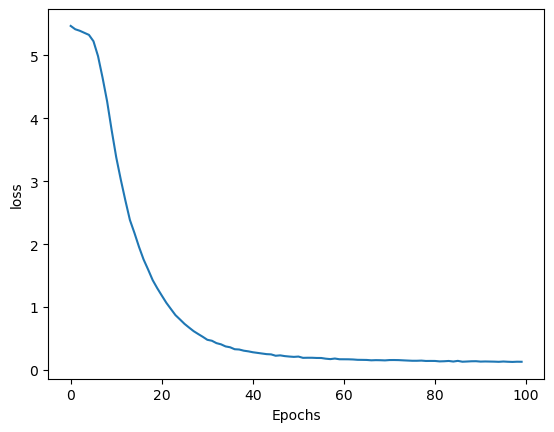

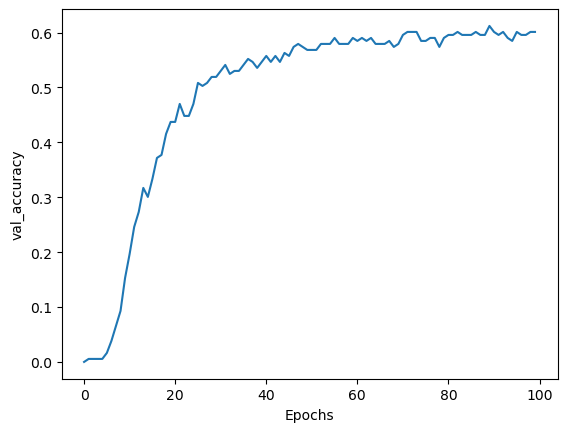

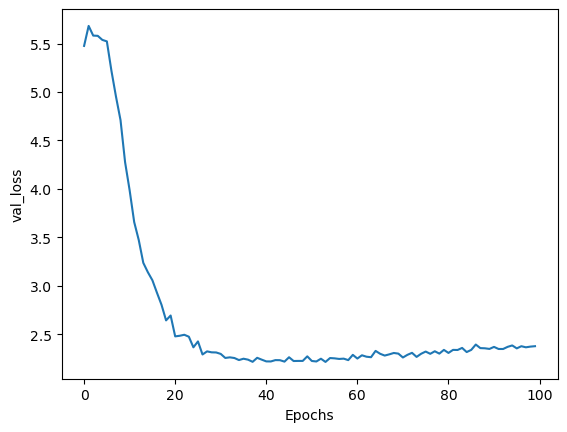

In [8]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "val_accuracy")
plot_graphs(history, "val_loss")

### ini cuman mau check hasil tag jangan di-run ya

In [ ]:
try:
    user_input = input('Masukkan pertanyaan: ')
    user_input = ''.join([letters.lower() for letters in user_input if letters not in string.punctuation])
    texts_p = [user_input]
    
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = pad_sequences(prediction_input, maxlen=input_shape)
    
    predicted_output = model.predict(prediction_input)
    predicted_label_index = np.argmax(predicted_output)
    predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]
    
    print('Chatbot:', predicted_label)
except:
    print("Chatbot: Maaf, saya tidak memahami maksud Anda.")

1/1 [==============================] - 1s 1s/step
Chatbot: PMS (Sindrom Pra-Menstruasi)


### check output 

In [9]:
import random

while True:
    user_input = input('You: ')
    if user_input.lower() == 'goodbye':
        print("Chatbot: Goodbye!")
        break
    try:
        input_seq = tokenizer.texts_to_sequences([user_input])
        input_seq = pad_sequences(input_seq, maxlen=input_shape)
        predicted_label_seq = model.predict(input_seq)
        predicted_label = label_encoder.inverse_transform([predicted_label_seq.argmax(axis=-1)])[0]
        print("tags:", predicted_label)

        # Pilih respons dari kategori tag
        responses_for_tag = responses.get(predicted_label, ["Chatbot: Maaf, saya tidak memahami maksud Anda."])
        response = random.choice(responses_for_tag)
        
        print("Chatbot:", response)
    except:
        print("Chatbot: Maaf, saya tidak memahami maksud Anda.")


1/1 [==============================] - 0s 331ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: pengertian_menstruasi
Chatbot: Menstruasi adalah proses alami yang terjadi pada wanita setiap bulan. Selama menstruasi, tubuh melepaskan lapisan rahim yang tidak diperlukan melalui vagina.
1/1 [==============================] - 0s 6ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: pengobatan_nyeri_menstruasi
Chatbot: Anda dapat mencoba tindakan non-obat untuk mengurangi nyeri menstruasi, seperti terapi panas dengan bantalan pemanas atau botol air panas yang ditempatkan di perut bagian bawah, relaksasi otot dengan teknik pernapasan dalam, pijatan lembut, atau yoga. Latihan fisik teratur dan makan makanan yang sehat juga dapat membantu mengurangi gejala nyeri menstruasi.
1/1 [==============================] - 0s 16ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: tentang_aku
Chatbot: aku adalah teman bicara anda untuk membahas permasalahan menstruasi. Jangan malu untuk bertanya dengan saya tentang permasalahan anda
1/1 [==============================] - 0s 15ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: agent.acquaintance
Chatbot: Saya adalah makhluk virtual, bukan orang yang nyata 
1/1 [==============================] - 0s 18ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: agent.acquaintance
Chatbot:  Saya adalah aplikasi percakapan 
1/1 [==============================] - 0s 18ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: agent.acquaintance
Chatbot:  Saya adalah aplikasi percakapan 
1/1 [==============================] - 0s 17ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: nyeri_pemasangan_IUD
Chatbot: Pemasangan IUD dapat menyebabkan sedikit ketidaknyamanan atau rasa sakit bagi beberapa wanita, tetapi tingkat rasa sakit ini dapat bervariasi dari satu individu ke individu lainnya. Beberapa wanita mungkin hanya merasa sedikit ketidaknyamanan, sementara yang lain mungkin mengalami rasa sakit yang lebih signifikan. Dokter biasanya akan memberikan nasihat dan panduan untuk mengatasi rasa sakit selama pemasangan.
